In [1]:

from analysis import *

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC","Latitude","Longitude","Euler_X (deg)","Euler_Y (deg)",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines", "LoadCell_1","LoadCell_2","LoadCell_3","LoadCell_4","LoadCell_5","LoadCell_6","M_tot_X","M_tot_Y","M_front_X","M_front_Y","M_back_X","M_back_Y","P_front_X","P_front_Y","P_back_X","P_back_Y"
]
df = pd.read_csv("all_data.csv")
MAX_NULL_RATIO = 0.2

## I. All together

In [2]:


df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)
df_numeric.dropna(subset=["SOG"], inplace=True)

print(f"Variables utilisées:", df_numeric.columns.tolist())
print(f"Number of rows after filtering: {len(df_numeric)}")


Variables utilisées: ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']
Number of rows after filtering: 80131



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 80131
- Removed samples with NaNs: 10185
- Final samples: 69946

Correlation with SOG:


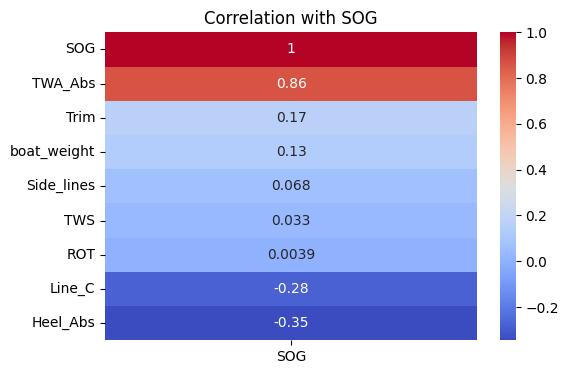


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,245603.178724,1.0,190941.151809,0.000000e+00,0.731917
TWS,5470.379232,1.0,4252.878635,0.000000e+00,0.057324
Side_lines,5242.427423,1.0,4075.660322,0.000000e+00,0.055067
boat_weight,4486.106411,1.0,3487.667911,0.000000e+00,0.047500
Line_C,3068.377586,1.0,2385.472181,0.000000e+00,0.032984
Trim,1295.699388,1.0,1007.325454,1.680344e-219,0.014199
Heel_Abs,694.461628,1.0,539.900598,5.609672e-119,0.007661
ROT,65.090666,1.0,50.603933,1.140980e-12,0.000723
Residual,89958.342388,69937.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.797
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
2.488 * TWA_Abs
0.795 * Side_lines
0.614 * Line_C
0.287 * TWS
0.280 * boat_weight
-0.149 * Trim
0.125 * Heel_Abs
0.031 * ROT


,feature,coefficient
5,TWA_Abs,2.488137
3,Side_lines,0.794819
1,Line_C,0.614360
6,TWS,0.286701
7,boat_weight,0.280399
4,Trim,-0.149148
0,Heel_Abs,0.124972
2,ROT,0.030548


In [3]:
full_analysis(df_numeric, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

## II Upwind:

### II.1. All upwind data

In [4]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 48787



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 48787
- Removed samples with NaNs: 5689
- Final samples: 43098

Correlation with SOG:


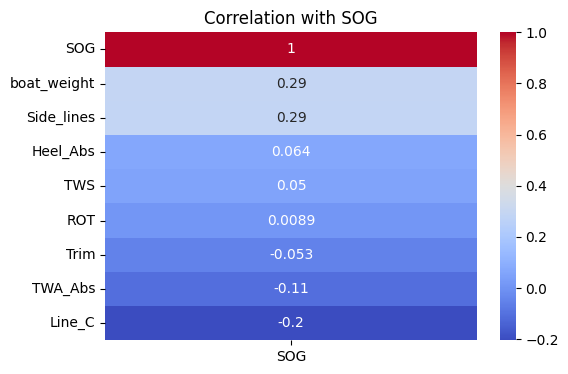


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,2859.476887,1.0,2408.478094,0.000000e+00,0.052937
Side_lines,2644.230676,1.0,2227.180674,0.000000e+00,0.049148
Line_C,1393.542980,1.0,1173.752358,8.038926e-254,0.026518
Trim,543.184839,1.0,457.513328,5.611190e-101,0.010506
TWS,344.895684,1.0,290.498484,6.325394e-65,0.006697
Heel_Abs,96.925960,1.0,81.638727,1.699743e-19,0.001891
TWA_Abs,12.808045,1.0,10.787951,1.022444e-03,0.000250
ROT,3.962059,1.0,3.337160,6.773834e-02,0.000077
Residual,51157.616866,43089.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.173
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.764 * Side_lines
0.546 * Line_C
0.282 * boat_weight
-0.117 * Trim
0.097 * TWS
0.051 * Heel_Abs
-0.019 * TWA_Abs
0.010 * ROT


,feature,coefficient
3,Side_lines,0.763931
1,Line_C,0.546272
7,boat_weight,0.282225
4,Trim,-0.116614
6,TWS,0.096577
0,Heel_Abs,0.050872
5,TWA_Abs,-0.018921
2,ROT,0.009782


In [5]:
full_analysis(df_numeric_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [6]:
gian_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Gian Stragiotti") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 24390



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 24390
- Removed samples with NaNs: 74
- Final samples: 24316

Correlation with SOG:


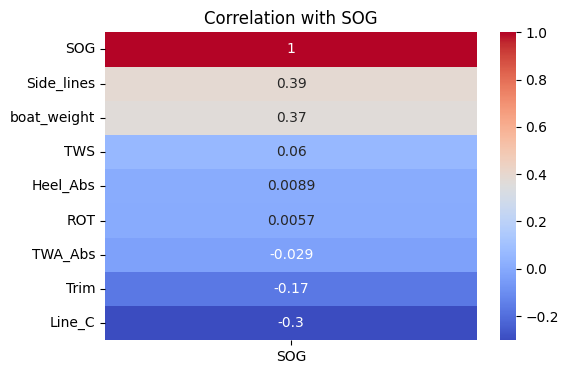


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
Side_lines,2548.788780,1.0,2594.069268,0.000000e+00,0.096430
Line_C,1443.551238,1.0,1469.196637,3.705227e-312,0.056998
TWS,669.994061,1.0,681.896836,2.866545e-148,0.027288
Trim,615.034728,1.0,625.961123,2.011325e-136,0.025106
boat_weight,162.091074,1.0,164.970702,1.230812e-37,0.006741
TWA_Abs,86.758057,1.0,88.299357,6.105745e-21,0.003620
ROT,4.515232,1.0,4.595447,3.206687e-02,0.000189
Heel_Abs,1.561062,1.0,1.588795,2.075105e-01,0.000065
Residual,23882.711860,24307.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.250
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
1.160 * Side_lines
0.811 * Line_C
0.207 * TWS
-0.161 * Trim
0.126 * boat_weight
0.066 * TWA_Abs
0.014 * ROT
-0.009 * Heel_Abs


,feature,coefficient
3,Side_lines,1.160160
1,Line_C,0.810910
6,TWS,0.206524
4,Trim,-0.161363
7,boat_weight,0.126144
5,TWA_Abs,0.066112
2,ROT,0.013892
0,Heel_Abs,-0.008725


In [7]:
full_analysis(df_numeric_gian_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.2.2. Upwind: Karl

In [8]:
karl_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Karl Maeder") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")

Number of rows after filtering: 24397



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Removed features (> 20% NaN): ['Side_lines']

Selected features (7): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 24397
- Removed samples with NaNs: 31
- Final samples: 24366

Correlation with SOG:


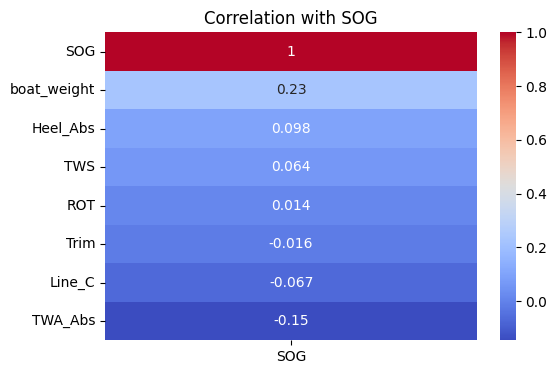


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,2066.082993,1.0,1750.550725,0.000000e+00,0.067049
Heel_Abs,539.449091,1.0,457.064406,1.755759e-100,0.018419
TWS,233.675027,1.0,197.988168,8.598238e-45,0.008063
TWA_Abs,139.315201,1.0,118.038979,1.965333e-27,0.004823
Trim,74.162125,1.0,62.836083,2.342191e-15,0.002573
Line_C,23.409804,1.0,19.834658,8.481305e-06,0.000814
ROT,5.609424,1.0,4.752753,2.926100e-02,0.000195
Residual,28748.466883,24358.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.096
Used features: 7
Polynomial terms generated: 7

Top terms in formula:
0.310 * boat_weight
0.154 * Heel_Abs
0.115 * TWS
-0.087 * TWA_Abs
-0.057 * Trim
-0.035 * Line_C
0.016 * ROT


,feature,coefficient
6,boat_weight,0.310230
0,Heel_Abs,0.154405
5,TWS,0.115189
4,TWA_Abs,-0.086735
3,Trim,-0.056778
1,Line_C,-0.035450
2,ROT,0.015523


In [9]:
full_analysis(df_numeric_karl_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.2.3. Upwind: Karl vs Gian t_test

In [10]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 31.779, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [11]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 24391



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 24391
- Removed samples with NaNs: 3372
- Final samples: 21019

Correlation with SOG:


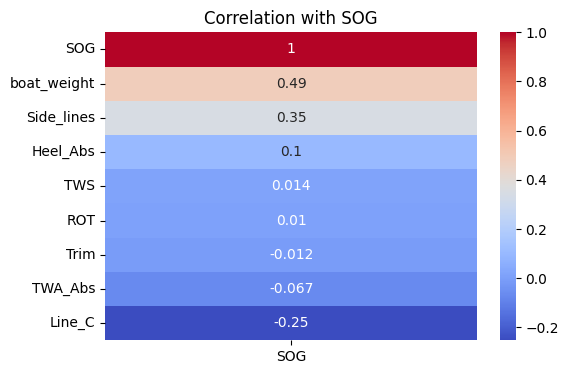


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,5248.607276,1.0,5057.696986,0.000000e+00,1.940216e-01
Side_lines,1033.068038,1.0,995.491723,1.618992e-213,4.523833e-02
Line_C,476.714879,1.0,459.375084,7.896866e-101,2.139676e-02
Trim,216.690251,1.0,208.808465,4.205390e-47,9.840725e-03
TWA_Abs,203.910997,1.0,196.494038,1.928636e-44,9.265748e-03
Heel_Abs,107.752591,1.0,103.833251,2.507144e-24,4.917783e-03
TWS,0.815977,1.0,0.786297,3.752324e-01,3.742348e-05
ROT,0.003852,1.0,0.003712,9.514190e-01,1.766749e-07
Residual,21803.053675,21010.0,NaN,NaN,5.000000e-01



Polynomial fit:

Model performance:
R²: 0.325
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.678 * Side_lines
0.547 * boat_weight
0.452 * Line_C
-0.110 * TWA_Abs
-0.106 * Trim
0.077 * Heel_Abs
0.007 * TWS
0.000 * ROT


,feature,coefficient
3,Side_lines,0.677812
7,boat_weight,0.546648
1,Line_C,0.451805
5,TWA_Abs,-0.109731
4,Trim,-0.105868
0,Heel_Abs,0.076679
6,TWS,0.006669
2,ROT,0.000437


In [12]:
full_analysis(df_numeric_master_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.3.2 Slave

In [13]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 24396



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 24396
- Removed samples with NaNs: 2317
- Final samples: 22079

Correlation with SOG:


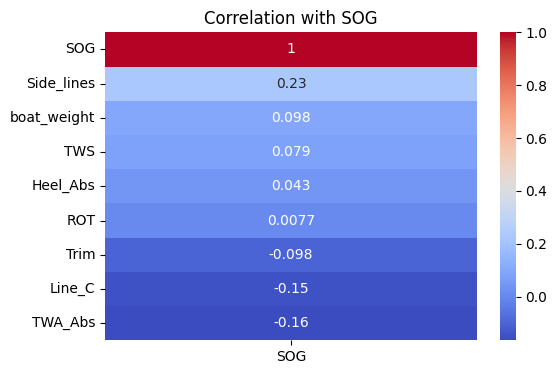


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
Side_lines,1553.919666,1.0,1345.147488,6.464811e-286,0.057448
Line_C,920.703343,1.0,797.005029,2.770934e-172,0.034854
Trim,239.413954,1.0,207.248216,8.917822e-47,0.009303
TWS,156.927303,1.0,135.843810,2.666311e-31,0.006117
TWA_Abs,125.936760,1.0,109.016908,1.844661e-25,0.004915
boat_weight,9.543496,1.0,8.261308,4.053761e-03,0.000374
Heel_Abs,5.551537,1.0,4.805677,2.837652e-02,0.000218
ROT,0.848572,1.0,0.734564,3.914170e-01,0.000033
Residual,25495.350750,22070.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.114
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.827 * Side_lines
0.629 * Line_C
-0.108 * Trim
0.094 * TWS
-0.087 * TWA_Abs
0.024 * boat_weight
0.017 * Heel_Abs
-0.006 * ROT


,feature,coefficient
3,Side_lines,0.827105
1,Line_C,0.629078
4,Trim,-0.108125
6,TWS,0.093958
5,TWA_Abs,-0.087288
7,boat_weight,0.024085
0,Heel_Abs,0.017138
2,ROT,-0.006337


In [14]:
full_analysis(df_numeric_slave_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.3. Upwind: Master vs Slave t_test

In [15]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 16.509, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [16]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 31344



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 31344
- Removed samples with NaNs: 4496
- Final samples: 26848

Correlation with SOG:


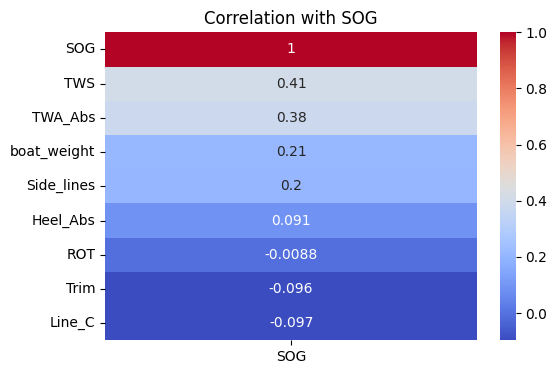


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,4387.953367,1.0,3616.766633,0.000000e+00,0.118755
TWA_Abs,3186.145007,1.0,2626.177169,0.000000e+00,0.089128
Side_lines,1733.965140,1.0,1429.219214,9.237669e-305,0.050559
Line_C,1442.853566,1.0,1189.270759,4.836281e-255,0.042431
boat_weight,1373.326860,1.0,1131.963434,4.198371e-243,0.040469
Heel_Abs,471.224623,1.0,388.406473,7.453591e-86,0.014265
Trim,286.233597,1.0,235.927786,5.109984e-53,0.008714
ROT,70.149986,1.0,57.821063,2.964633e-14,0.002150
Residual,32561.758155,26839.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.371
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.698 * Side_lines
0.636 * Line_C
0.476 * TWS
0.411 * TWA_Abs
0.261 * boat_weight
0.175 * Heel_Abs
-0.125 * Trim
-0.053 * ROT


,feature,coefficient
3,Side_lines,0.698415
1,Line_C,0.635582
6,TWS,0.475566
5,TWA_Abs,0.410776
7,boat_weight,0.260743
0,Heel_Abs,0.175045
4,Trim,-0.124600
2,ROT,-0.052860


In [17]:

full_analysis(df_numeric_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [18]:
gian_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Gian Stragiotti") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 15667



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 15667
- Removed samples with NaNs: 53
- Final samples: 15614

Correlation with SOG:


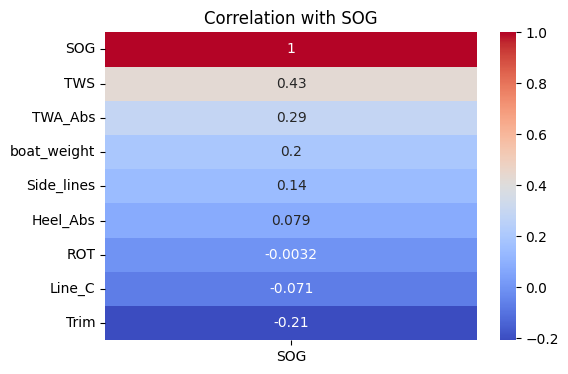


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,4345.499892,1.0,4100.945056,0.000000e+00,0.208107
Side_lines,1201.351018,1.0,1133.741719,5.406315e-240,0.067732
TWA_Abs,1127.409729,1.0,1063.961677,7.971268e-226,0.063829
Trim,558.302069,1.0,526.882100,1.060563e-114,0.032661
Heel_Abs,503.532878,1.0,475.195195,8.350172e-104,0.029552
Line_C,472.288849,1.0,445.709508,1.426841e-97,0.027769
boat_weight,120.891126,1.0,114.087649,1.539829e-26,0.007258
ROT,4.029179,1.0,3.802426,5.119626e-02,0.000244
Residual,16535.585062,15605.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.381
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.894 * Side_lines
0.652 * TWS
0.549 * Line_C
0.332 * TWA_Abs
0.237 * Heel_Abs
-0.226 * Trim
-0.153 * boat_weight
-0.017 * ROT


,feature,coefficient
3,Side_lines,0.893856
6,TWS,0.652132
1,Line_C,0.549181
5,TWA_Abs,0.332324
0,Heel_Abs,0.236512
4,Trim,-0.226478
7,boat_weight,-0.153161
2,ROT,-0.016624


In [19]:

full_analysis(df_numeric_gian_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.2.2. Downwind: Karl

In [20]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 15677



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Removed features (> 20% NaN): ['Side_lines']

Selected features (7): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 15677
- Removed samples with NaNs: 605
- Final samples: 15072

Correlation with SOG:


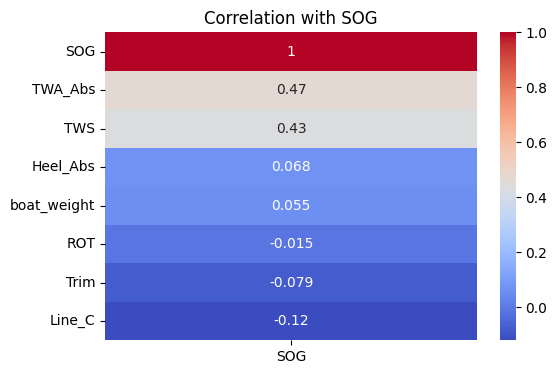


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,2525.138945,1.0,2046.763995,0.000000e+00,0.119619
TWS,1144.794065,1.0,927.918552,7.906718e-198,0.058024
boat_weight,978.843840,1.0,793.406768,3.634947e-170,0.050034
Heel_Abs,857.798628,1.0,695.292966,7.758419e-150,0.044120
Trim,444.415748,1.0,360.223406,2.121610e-79,0.023354
ROT,137.242985,1.0,111.242988,6.444999e-26,0.007331
Line_C,0.623391,1.0,0.505293,4.771947e-01,0.000034
Residual,18584.796863,15064.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.337
Used features: 7
Polynomial terms generated: 7

Top terms in formula:
0.522 * TWA_Abs
0.376 * TWS
0.271 * Heel_Abs
0.268 * boat_weight
-0.190 * Trim
-0.099 * ROT
-0.007 * Line_C


,feature,coefficient
4,TWA_Abs,0.521529
5,TWS,0.375582
0,Heel_Abs,0.271419
6,boat_weight,0.268086
3,Trim,-0.190160
2,ROT,-0.098959
1,Line_C,-0.007222


In [21]:
full_analysis(df_numeric_karl_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.2.3. Downwind: Karl vs Gian t_test

In [22]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -38.976, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [23]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 15670



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 15670
- Removed samples with NaNs: 2413
- Final samples: 13257

Correlation with SOG:


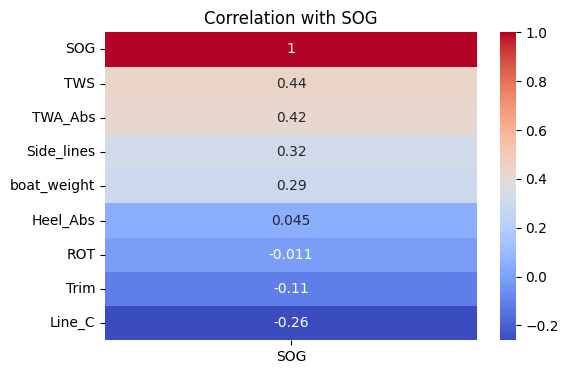


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,2362.835887,1.0,2277.291269,0.000000e+00,0.146683
TWS,2144.063121,1.0,2066.438999,0.000000e+00,0.134934
boat_weight,1157.202724,1.0,1115.307108,7.339410e-235,0.077650
Side_lines,365.823045,1.0,352.578709,1.181303e-77,0.025924
Trim,312.228365,1.0,300.924382,1.128092e-66,0.022210
Heel_Abs,298.219683,1.0,287.422874,8.514473e-64,0.021235
Line_C,99.923742,1.0,96.306082,1.175780e-22,0.007217
ROT,56.229097,1.0,54.193367,1.924139e-13,0.004074
Residual,13745.650484,13248.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.454
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.510 * Side_lines
0.482 * TWA_Abs
0.457 * TWS
0.341 * boat_weight
0.261 * Line_C
0.197 * Heel_Abs
-0.187 * Trim
-0.067 * ROT


,feature,coefficient
3,Side_lines,0.509877
5,TWA_Abs,0.482087
6,TWS,0.457265
7,boat_weight,0.341257
1,Line_C,0.261127
0,Heel_Abs,0.196741
4,Trim,-0.187261
2,ROT,-0.067364


In [24]:
full_analysis(df_numeric_master_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.2 Downwind Slave

In [25]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 15674



Initial features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Selected features (8): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight']

Data cleaning:
- Initial samples: 15674
- Removed samples with NaNs: 2083
- Final samples: 13591

Correlation with SOG:


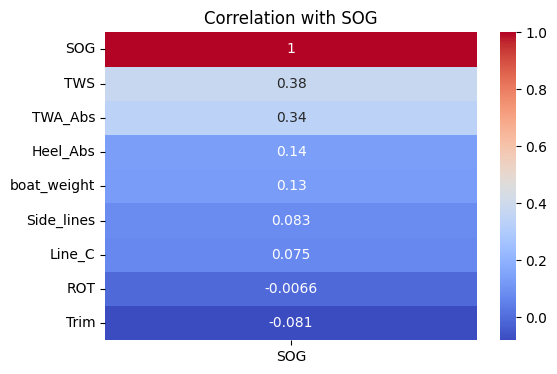


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,2001.787136,1.0,1570.935319,0.000000e+00,0.103672
Line_C,1710.777747,1.0,1342.560924,2.234909e-280,0.089956
Side_lines,1229.019369,1.0,964.493127,1.228113e-204,0.066304
TWA_Abs,1110.253835,1.0,871.289924,1.168319e-185,0.060283
boat_weight,406.244473,1.0,318.807020,1.681831e-70,0.022934
Heel_Abs,185.597675,1.0,145.650823,2.292808e-33,0.010610
Trim,58.789791,1.0,46.136254,1.148986e-11,0.003385
ROT,18.088455,1.0,14.195212,1.654857e-04,0.001044
Residual,17307.060674,13582.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.347
Used features: 8
Polynomial terms generated: 8

Top terms in formula:
0.882 * Line_C
0.730 * Side_lines
0.477 * TWS
0.363 * TWA_Abs
0.201 * boat_weight
0.156 * Heel_Abs
-0.079 * Trim
-0.038 * ROT


,feature,coefficient
1,Line_C,0.881849
3,Side_lines,0.729890
6,TWS,0.477071
5,TWA_Abs,0.363128
7,boat_weight,0.201399
0,Heel_Abs,0.155912
4,Trim,-0.078922
2,ROT,-0.037738


In [26]:
full_analysis(df_numeric_slave_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.3. Downwind: Master vs Slave t_test

In [27]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 0.953, p-value: 0.340575073568009
The difference is not statistically significant, keeping data combined.
